In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import proplot as pplt
import geopandas as gpd
import rioxarray as rioxr


C:\Users\zhuyu\AppData\Roaming\Python\Python39\site-packages\proplot\__init__.py:73: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


In [2]:
#kh9_sta_nm=pth+'/kh-9/Myinfo/dem-dh-nongla.csv'
#topo_sta_nm=pth+'/dxt/Myinfo/dem-dh-nongla.csv'
kh9_bf_pth='results/kh9_orig_dh.tif'
topo_bf_pth='results/dxt_orig_dh.tif'   #校正前dh

kh9_af_pth='results/kh9_dh.tif'
topo_af_pth='results/g0336_dh_final.tif' ##校正后dh
overlay_bd='data/over_bd.shp'  ##两个叠置区
dem='data/srtm_p.tif'  #dem
gla='data/first_inventory_revise.shp' ###冰川

In [3]:
df_gla=gpd.read_file(gla)
df_over=gpd.read_file(overlay_bd)
#df_over.plot()
ds_dem0=xr.open_dataset(dem,engine='rasterio')
ds_dem=ds_dem0.rio.clip(df_over.geometry)

In [4]:
kh9_bf=xr.open_dataset(kh9_bf_pth,engine='rasterio')
kh9_af=xr.open_dataset(kh9_af_pth,engine='rasterio')

dxt_bf=xr.open_dataset(topo_bf_pth,engine='rasterio')
dxt_af=xr.open_dataset(topo_af_pth,engine='rasterio')

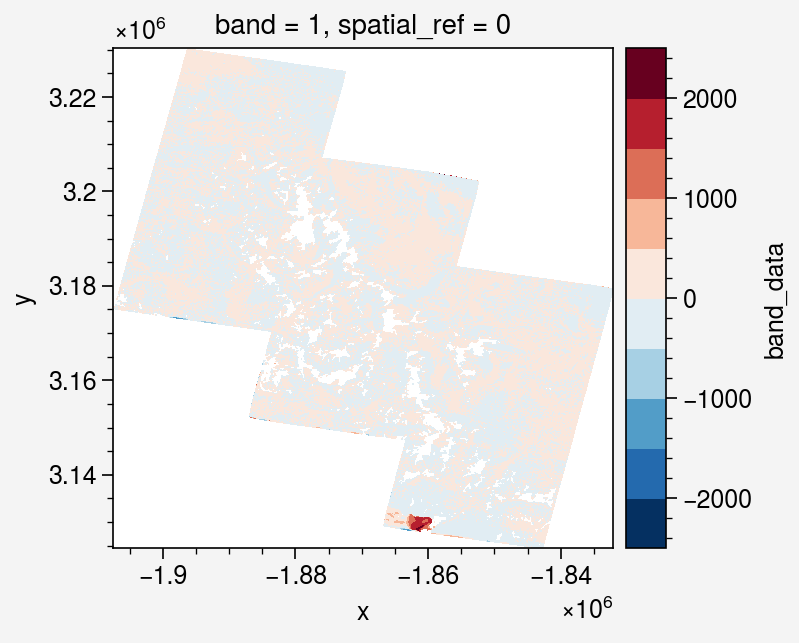

In [5]:
fig,ax=pplt.subplots((1,1))
dxt_af['band_data'].plot()

In [6]:
##最近邻插值 确保两个输入要素的行列一致
##ds_dh_inp=ds_dh.interp(x=ds_dem.x.values,y=ds_dem.y.values,method='nearest')
###topo  before
df1=dxt_bf.rio.clip(df_over.geometry)
df10=df1.where((df1<100)&(df1>-100))
df11=df10.interp(x=ds_dem.x.values,y=ds_dem.y.values,method='nearest')
#--topo after
df2=dxt_af.rio.clip(df_over.geometry)
df20=df2.where((df2<100)&(df2>-100))
df22=df20.interp(x=ds_dem.x.values,y=ds_dem.y.values,method='nearest')
###kh9
df3=kh9_bf.rio.clip(df_over.geometry)
df30=df3.where((df3<100)&(df3>-100))
df33=df30.interp(x=ds_dem.x.values,y=ds_dem.y.values,method='nearest')
#--topo after
df4=kh9_af.rio.clip(df_over.geometry)
df40=df4.where((df4<100)&(df4>-100))
df44=df40.interp(x=ds_dem.x.values,y=ds_dem.y.values,method='nearest')

In [7]:
dff11=df11['band_data'].to_dataframe().drop(['spatial_ref'],axis=1)
dff22=df22['band_data'].to_dataframe().drop(['spatial_ref'],axis=1)
dff33=df33['band_data'].to_dataframe().drop(['spatial_ref'],axis=1)
dff44=df44['band_data'].to_dataframe().drop(['spatial_ref'],axis=1)
dffdem=(ds_dem['band_data']).to_dataframe().drop(['spatial_ref'],axis=1)

In [8]:
dff_all=pd.concat([dff11,dff22,dff33,dff44,dffdem],axis=1)

In [9]:
dff_all.columns=['topo_bf','topo_af','kh9_bf','kh9_af','dem']

In [10]:
crs='''
PROJCS["Asia_North_Albers_Equal_Area_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",105],PARAMETER["standard_parallel_1",25],PARAMETER["standard_parallel_2",47],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'''

In [11]:
ds_all=dff_all.to_xarray()
ds_all0=ds_all.rio.write_crs(crs)

In [12]:
ds_gla=ds_all0.rio.clip(df_gla.geometry)   ###冰川区
ds_gla_na=ds_all0.rio.clip(df_gla.geometry,invert=True) ###非冰川区

In [13]:
df_nog=ds_gla_na.to_dataframe().drop('spatial_ref',axis=1)  ###非冰川区的专为dataframe 进行统计绘图

In [14]:
'''generate strip positions and interval center by interval'''
def ExtractByStrip(df,strip_sign,outsign,interval):
    #val_min=df[strip_sign].min()
    #val_max=df[strip_sign].max()
    val_min=1000
    val_max=8500
    #print(val_min,val_max)
    #n=int((val_max-val_min)/interval)
    df[outsign]=-1
    x=val_min
    while x<val_max:
        y=x+interval
        if y>=val_max:
            y=val_max+1
        df.loc[((df[strip_sign]>=x)&(df[strip_sign]<y)),outsign] =(x+y)/2.0
        x=y
    return df

In [15]:
df_sta=ExtractByStrip(df_nog,'dem','flag',200)

C:\Users\zhuyu\AppData\Local\Temp\ipykernel_14984\1302932519.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8450.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[((df[strip_sign]>=x)&(df[strip_sign]<y)),outsign] =(x+y)/2.0


### 结果绘图

In [16]:
####绘图用统计
dff_pt=df_sta.groupby('flag')
q25=dff_pt.quantile(0.25)
q75=dff_pt.quantile(0.75)
q05=dff_pt.quantile(0.05)
q95=dff_pt.quantile(0.95)
std=dff_pt.std()
mea=dff_pt.mean()

In [19]:
kh9prj=kh9_af.rio.reproject('epsg:4326')
kh9prj=kh9prj.where((kh9prj<100)&(kh9prj>-100))
dxtprj=dxt_af.rio.reproject('epsg:4326')
dxtprj=dxtprj.where((dxtprj<80)&(dxtprj>-80))

In [20]:
###插值 让绘图更快
kh9prjin=kh9prj.interp(x=kh9prj.x.values[::5],y=kh9prj.y.values[::5])['band_data']
dxtprjin=dxtprj.interp(x=dxtprj.x.values[::5],y=dxtprj.y.values[::5])['band_data']

In [ ]:
[nmad(df_nog['topo_bf']),nmad(df_nog['topo_af'])],[nmad(df_nog['kh9_bf']),nmad(df_nog['kh9_af'])]

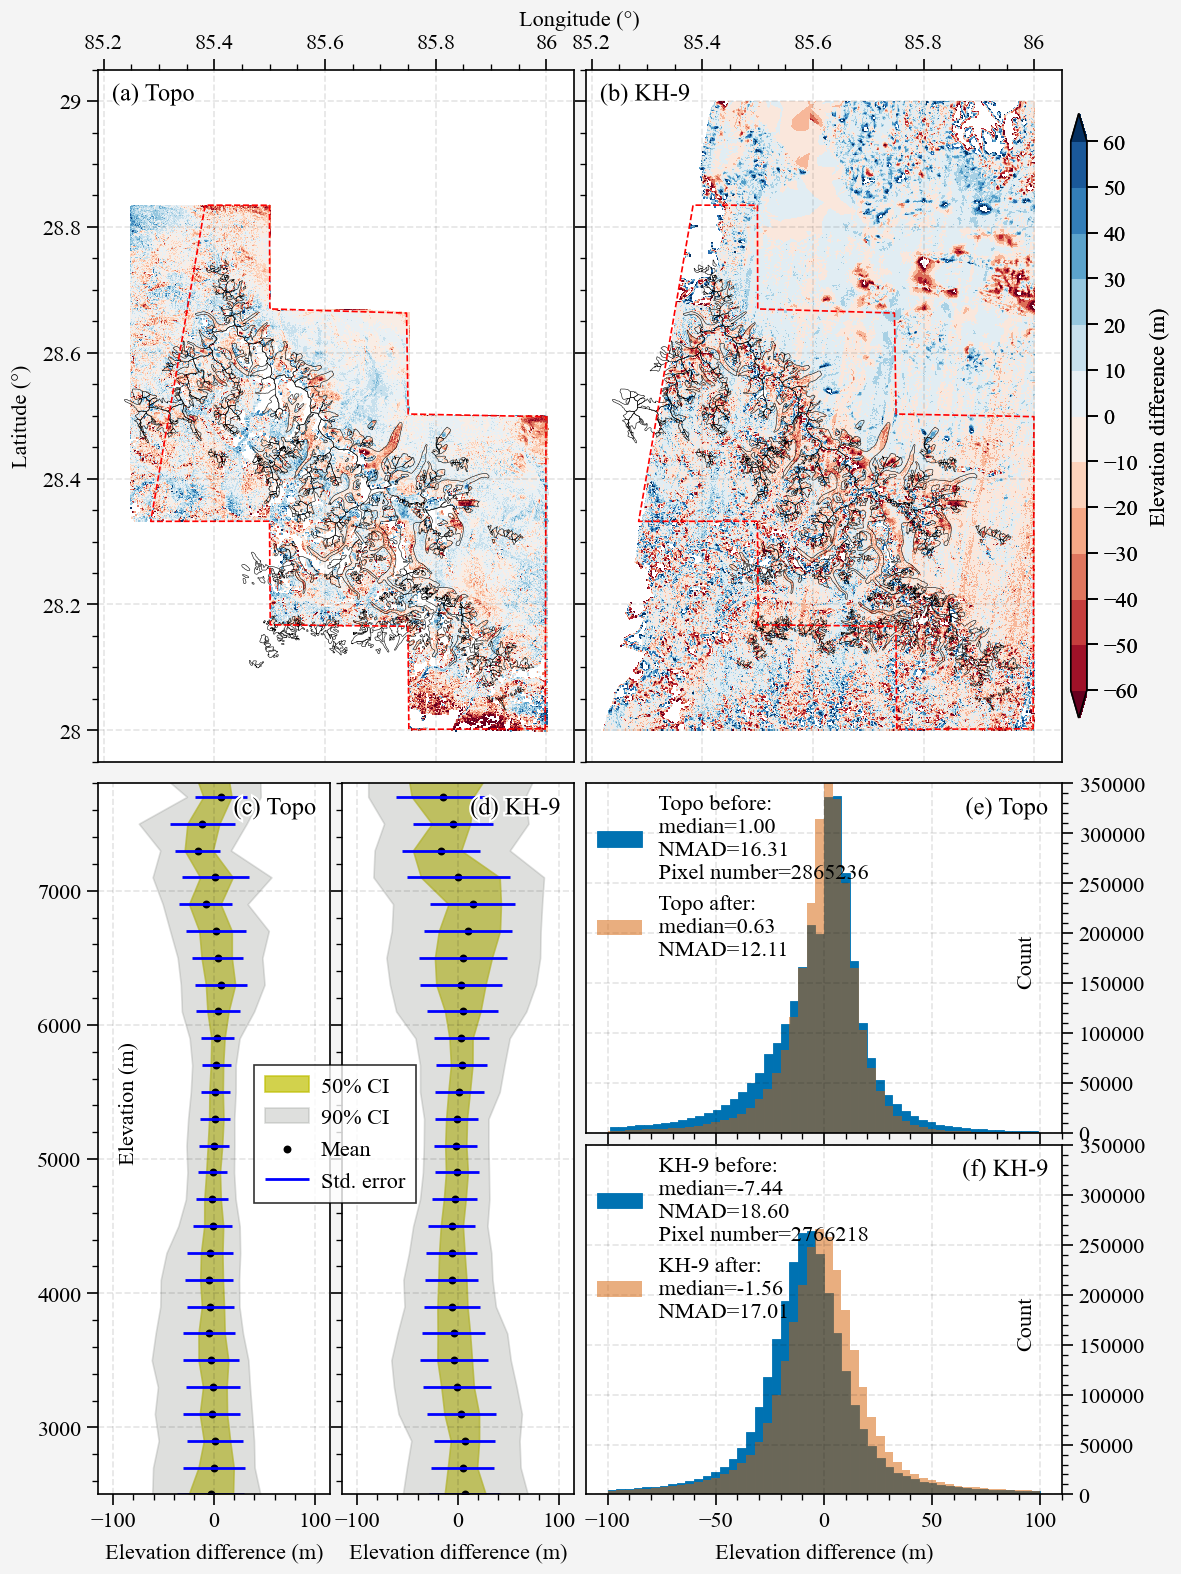

In [268]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc")#中文支持，很重要
font1 = FontProperties(family='times new roman',style='normal',weight='normal') #设置新罗马

plt.rcParams['font.sans-serif']=['times new roman']
plt.rcParams['font.size']=8
plt.rcParams['grid.linestyle']='--'
arr=[[5,5,5,5,6,6,6,6],
     [5,5,5,5,6,6,6,6],
     [1,1,2,2,3,3,3,3],
     [1,1,2,2,4,4,4,4]]
fig, axs = pplt.subplots(arr, figsize=('15cm','20cm'),
                         sharex=0,sharey=0,hspace=0.55,wspace=0.54)
################ topo
lg1=axs[0].fill_betweenx(q25.index,q25['topo_af'].values, q75['topo_af'].values,alpha=0.7,color='y')
lg2=axs[0].fill_betweenx(q05.index,q05['topo_af'].values, q95['topo_af'].values,alpha=0.3,color='gray')
lg3=axs[0].scatter(mea['topo_af'].values,mea.index,marker='.',s=20,color='k')

for i,me in enumerate(mea['topo_af'].values):
    lg4=axs[0].hlines(std.index[i], me-std['topo_af'].values[i], me+std['topo_af'].values[i], lw=1,color='b')
###############kh-9
lg11=axs[1].fill_betweenx(q25.index,q25['kh9_af'].values, q75['kh9_af'].values,alpha=0.7,color='y')
lg22=axs[1].fill_betweenx(q05.index,q05['kh9_af'].values, q95['kh9_af'].values,alpha=0.3,color='gray')
lg33=axs[1].scatter(mea['kh9_af'].values,mea.index,marker='.',s=20,color='k')

for j,me1 in enumerate(mea['kh9_af'].values):
    lg44=axs[1].hlines(std.index[j], me1-std['kh9_af'].values[j], me1+std['kh9_af'].values[j], lw=1,color='b')

axs[0].format(ylim=[2500,7800],xlim=[-115,115],ylabel='',xlabel='Elevation difference (m)')
axs[1].format(ylim=[2500,7800],xlim=[-115,115],ylabel='',xlabel='Elevation difference (m)',yticklabels=[])
axs[1].legend([lg11,lg22,lg33,lg44],['50% CI','90% CI','Mean','Std. error'],loc=3,
           bbox_to_anchor=(-0.38, 0.41),ncol=1,borderaxespad=0)

axs[0].text(-95,5000,'Elevation (m)',rotation='vertical')
#############################
aaa=df_sta.topo_bf.dropna().values
aaa1=df_sta.topo_af.dropna().values
bbb=df_sta.kh9_bf.dropna().values
bbb1=df_sta.kh9_af.dropna().values

axs[2].hist(aaa,50,histtype='bar',label=' Topo before:\n median=%.2f\n NMAD=16.31\n Pixel number=%d'%(np.median(aaa),len(aaa)))
axs[2].hist(aaa1,50,histtype='bar',alpha=0.5,label=' Topo after:\n median=%.2f\n NMAD=12.11'%(np.median(aaa1)))
axs[3].hist(bbb,50,histtype='bar',label=' KH-9 before:\n median=%.2f\n NMAD=18.60\n Pixel number=%d'%(np.mean(bbb),len(bbb)))
axs[3].hist(bbb1,50,histtype='bar',alpha=0.5,label=' KH-9 after:\n median=%.2f\n NMAD=17.01'%(np.mean(bbb1)))

axs[2].format(ylim=[0,350000],xlim=[-110,110],ytickloc='right',xticklabels=[])
axs[3].format(ylim=[0,350000],xlim=[-110,110],ytickloc='right',xlabel='Elevation difference (m)')
axs[2].legend(loc=2,ncol=1,frameon=False,fontsize=6.5)
axs[3].legend(loc=2,ncol=1,frameon=False,fontsize=6.5)

axs[2].text(89,150000,'Count',rotation='vertical')
axs[3].text(89,150000,'Count',rotation='vertical')
#################
cs1=axs[5].pcolormesh(kh9prjin[0],colorbar=False,cmap='RdBu')
cs2=axs[4].pcolormesh(dxtprjin[0],colorbar=False,extend='both',cmap='RdBu',levels=range(-60,65,10))
#cs2=dxtprjin.plot(ax=axs[4],add_colorbar=False)
(df_gla.to_crs('epsg:4326')).plot(ax=axs[5],edgecolor='k',facecolor='none',lw=0.2)
(df_gla.to_crs('epsg:4326')).plot(ax=axs[4],edgecolor='k',facecolor='none',lw=0.2)

(df_over.to_crs('epsg:4326')).plot(ax=axs[4],edgecolor='r',facecolor='none',ls='--')
(df_over.to_crs('epsg:4326')).plot(ax=axs[5],edgecolor='r',facecolor='none',ls='--')

#axs[4].colorbar(cs1, loc='b',length=0.85,width=0.080,tickminor=False,pad=0,extend='both')
axs[5].colorbar(cs2, label='Elevation difference (m)',loc='r',length=0.85,width=0.080,
                tickminor=False,pad=0.4,extend='both')

axs[4:6].format(ylim=(27.95,29.05),xlim=(85.19,86.05),title='',xlabel='',ylabel='')

##############
axs[4].text(85.95,29.12,'Longitude (°)')
axs[0].format(urtitle='(c) Topo')
axs[1].format(urtitle='(d) KH-9')
axs[2].format(urtitle='(e) Topo')
axs[3].format(urtitle='(f) KH-9')
axs[4].format(ultitle='(a) Topo',xgrid='--',ygrid='--',xtickloc='top',ylabel='Latitude (°)')
axs[5].format(ultitle='(b) KH-9',xgrid='--',ygrid='--',xtickloc='top',yticklabels=[])
plt.savefig('Figs/comparision_topo-kh9_xxbm-large.tif',dpi=600,bbox_inches = 'tight')

#### 空间误差图绘制

In [22]:
from xdem.spatialstats import nmad
import xdem
import geoutils as gu

In [23]:
kh9_bf1=kh9_bf.rio.clip(df_over.geometry)
kh9_af1=kh9_af.rio.clip(df_over.geometry)
dxt_bf1=dxt_bf.rio.clip(df_over.geometry)
dxt_af1=dxt_af.rio.clip(df_over.geometry)
kh9_bf_pth1='results/kh9_bf_clp.tif'
topo_bf_pth1='results/topo_bf_clp.tif'
kh9_af_pth1='results/kh9_af_clp.tif'
topo_af_pth1='results/topo_af_clp.tif'
kh9_bf1['band_data'].rio.to_raster(kh9_bf_pth1)
kh9_af1.where((kh9_af1>-100)&(kh9_af1<100))['band_data'].rio.to_raster(kh9_af_pth1)

dxt_bf1['band_data'].rio.to_raster(topo_bf_pth1)
dxt_af1.where((dxt_af1>-60)&(dxt_af1<60))['band_data'].rio.to_raster(topo_af_pth1)

In [54]:
def calhog(kh9_af_pth1,gla,dem):
    dh = xdem.DEM(kh9_af_pth1)
    
    ref_dem0 = xdem.DEM(dem)
    ref_dem=ref_dem0.reproject(dh)
    glacier_outlines = gu.Vector(gla)
    # Compute the slope and maximum curvature
    slope, planc, profc = xdem.terrain.get_terrain_attribute(
        dem=ref_dem, attribute=["slope", "planform_curvature", "profile_curvature"]
    )
    
    mask_glacier = glacier_outlines.create_mask(dh)
    # Remove values on unstable terrain
    dh_arr = dh[~mask_glacier].filled(np.nan)
    slope_arr = slope[~mask_glacier].filled(np.nan)
    planc_arr = planc[~mask_glacier].filled(np.nan)
    profc_arr = profc[~mask_glacier].filled(np.nan)
    maxc_arr = np.maximum(np.abs(planc_arr), np.abs(profc_arr))
    # Remove large outliers
    dh_arr[np.abs(dh_arr) > 3 * xdem.spatialstats.nmad(dh_arr)] = np.nan
    # Define bins for 2D binning
    custom_bin_slope = np.unique(
        np.concatenate(
            [
                np.nanquantile(slope_arr, np.linspace(0, 0.95, 20)),
                np.nanquantile(slope_arr, np.linspace(0.96, 0.99, 5)),
                np.nanquantile(slope_arr, np.linspace(0.991, 1, 10)),
            ]
        )
    )
    
    custom_bin_curvature = np.unique(
        np.concatenate(
            [
                np.nanquantile(maxc_arr, np.linspace(0, 0.95, 20)),
                np.nanquantile(maxc_arr, np.linspace(0.96, 0.99, 5)),
                np.nanquantile(maxc_arr, np.linspace(0.991, 1, 10)),
            ]
        )
    )
    
    # Perform 2D binning to estimate the measurement error with slope and maximum curvature
    df = xdem.spatialstats.nd_binning(
        values=dh_arr,
        list_var=[slope_arr, maxc_arr],
        list_var_names=["slope", "maxc"],
        statistics=["count", np.nanmedian, nmad],
        list_var_bins=[custom_bin_slope, custom_bin_curvature],
    )
    
    # Estimate an interpolant of the measurement error with slope and maximum curvature
    slope_curv_to_dh_err = xdem.spatialstats.interp_nd_binning(
        df, list_var_names=["slope", "maxc"], statistic="nmad", min_count=30
    )
    maxc = np.maximum(np.abs(profc), np.abs(planc))
    
    # Estimate a measurement error per pixel
    dh_err = slope_curv_to_dh_err((slope.data, maxc.data))
    z_dh = dh.data / dh_err
    z_dh.data[mask_glacier.data] = np.nan
    z_dh.data[np.abs(z_dh.data) > 3] = np.nan
    df_vgm = xdem.spatialstats.sample_empirical_variogram(
            values=z_dh.data.squeeze(),
            gsd=dh.res[0],
            subsample=5000,
            n_variograms=15,
            estimator="dowd",
            random_state=42,)

    func_sum_vgm, params_vgm = xdem.spatialstats.fit_sum_model_variogram(
        ["Gaussian", "Spherical"], empirical_variogram=df_vgm)   #"Spherical", Gaussian
    neff = xdem.spatialstats.neff_circular_approx_numerical(
    area=glacier_outlines.ds.area.sum(), params_variogram_model=params_vgm)
    return df_vgm,func_sum_vgm,params_vgm,neff

In [56]:
import warnings
warnings.filterwarnings("ignore")

In [57]:
df_vgm1,func_sum_vgm1,params_vgm1,neff1=calhog(kh9_af_pth1,gla,dem)
df_vgm2,func_sum_vgm2,params_vgm2,neff2=calhog(topo_af_pth1,gla,dem)

In [58]:
params_vgm1

,model,range,psill
0,gaussian,190.977648,0.999494
0,spherical,95453.690249,0.248619


In [59]:
params_vgm2

,model,range,psill
0,gaussian,208.416864,1.050019
0,spherical,37850.165249,0.153146


In [60]:
neff1,neff2

(6.175784587586542, 14.384087396600403)

In [142]:
from typing import Any, Callable, Iterable, Literal, TypedDict, overload
from xdem._typing import NDArrayf
import matplotlib
def plot_variogram(
    df: pd.DataFrame,
    list_fit_fun: list[Callable[[NDArrayf], NDArrayf]] = None,
    list_fit_fun_label: list[str] = None,
    ax: matplotlib.axes.Axes = None,
    xscale: str = "linear",
    xscale_range_split: list[float] = None,
    xlabel: str = None,
    ylabel: str = None,
    xlim: str = None,
    ylim: str = None,
    out_fname: str = None,
    flag=0
) -> None:

    # Check format of input dataframe
    expected_values = ["exp", "lags", "count"]
    for val in expected_values:
        if val not in df.columns.values:
            raise ValueError(f'The expected variable "{val}" is not part of the provided dataframe column names.')

    # Hide axes for the main subplot (which will be subdivded)
    ax.axis("off")

    if ylabel is None:
        ylabel = r"Variance [$\mu$ $\pm \sigma$]"
    if xlabel is None:
        xlabel = "Spatial lag (m)"

    init_gridsize = [10, 10]
    # Create parameters to split x axis into different linear scales
    # If there is no split, get parameters for a single subplot
    if xscale_range_split is None:
        nb_subpanels = 1
        if xscale == "log":
            xmin = [np.min(df.lags) / 2]
        else:
            xmin = [0]
        xmax = [np.max(df.lags)]
        xgridmin = [0]
        xgridmax = [init_gridsize[0]]
        gridsize = init_gridsize

    # Need a grid plot to show the sample count and the statistic
    grid = plt.GridSpec(gridsize[1], gridsize[0], wspace=0.5, hspace=0.5)

    # Loop over each subpanel
    for k in range(nb_subpanels):
        # First, an axis to plot the sample histogram
        ax0 = ax.inset_axes(grid[:3, xgridmin[k] : xgridmax[k]].get_position(fig).bounds)
        ax0.set_xscale(xscale)
        ax0.set_xticks([])

        # Plot the histogram manually with fill_between
        interval_var = [0] + list(df.lags)
        for i in range(len(df)):
            count = df["count"].values[i]
            ax0.fill_between(
                [interval_var[i], interval_var[i + 1]],
                [0] * 2,
                [count] * 2,
                facecolor=plt.cm.Greys(0.75),
                alpha=1,
                edgecolor="white",
                linewidth=0.5,
            )
        if k == 0:
            ax0.set_ylabel("Sample count")
            # Scientific format to avoid undesired additional space on the label side
            ax0.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
        else:
            ax0.set_yticks([])
        # Ignore warnings for log scales
        ax0.set_xlim((xmin[k], xmax[k]))

        # Now, plot the statistic of the data
        ax1 = ax.inset_axes(grid[3:, xgridmin[k] : xgridmax[k]].get_position(fig).bounds)

        # Get the lags bin centers
        bins_center = np.subtract(df.lags, np.diff([0] + df.lags.tolist()) / 2)

        # If all the estimated errors are all NaN (single run), simply plot the empirical variogram
        if np.all(np.isnan(df.err_exp)):
            ax1.scatter(bins_center, df.exp, label="Empirical variogram", color="blue", marker="x")
        # Otherwise, plot the error estimates through multiple runs
        else:
            ax1.errorbar(bins_center, df.exp, yerr=df.err_exp, label="Empirical variogram\n(std error)", fmt="x")

        # If a list of functions is passed, plot the modelled variograms
        if list_fit_fun is not None:
            for i, fit_fun in enumerate(list_fit_fun):
                x = np.linspace(xmin[k], xmax[k], 1000)
                
                #aaa
                y = fit_fun(x)
                if flag==1:
                    y[4]=1.05;y[3]=1.04;y[2]=1.03;y[1]=1.005

                if list_fit_fun_label is not None:
                    ax1.plot(x, y, linestyle="dashed", label=list_fit_fun_label[i], zorder=30)
                else:
                    ax1.plot(x, y, linestyle="dashed", color="black", zorder=30)

            if list_fit_fun_label is None:
                ax1.plot([], [], linestyle="dashed", color="black", label="Model fit")

        ax1.set_xscale(xscale)
        if nb_subpanels > 1 and k == (nb_subpanels - 1):
            ax1.xaxis.set_ticks(np.linspace(xmin[k], xmax[k], 3))
        elif nb_subpanels > 1:
            ax1.xaxis.set_ticks(np.linspace(xmin[k], xmax[k], 3)[:-1])

        if xlim is None:
            ax1.set_xlim((xmin[k], xmax[k]))
        else:
            ax1.set_xlim(xlim)

        if ylim is not None:
            ax1.set_ylim(ylim)
        else:
            if np.all(np.isnan(df.err_exp)):
                ax1.set_ylim((0, 1.05 * np.nanmax(df.exp)))
            else:
                ax1.set_ylim((0, np.nanmax(df.exp) + np.nanmean(df.err_exp)))

        if k == int(nb_subpanels / 2):
            ax1.set_xlabel(xlabel)
        if k == 0:
            ax1.set_ylabel(ylabel)
        else:
            ax1.set_yticks([])

    if out_fname is not None:
        plt.savefig(out_fname)
    return ax0,ax1

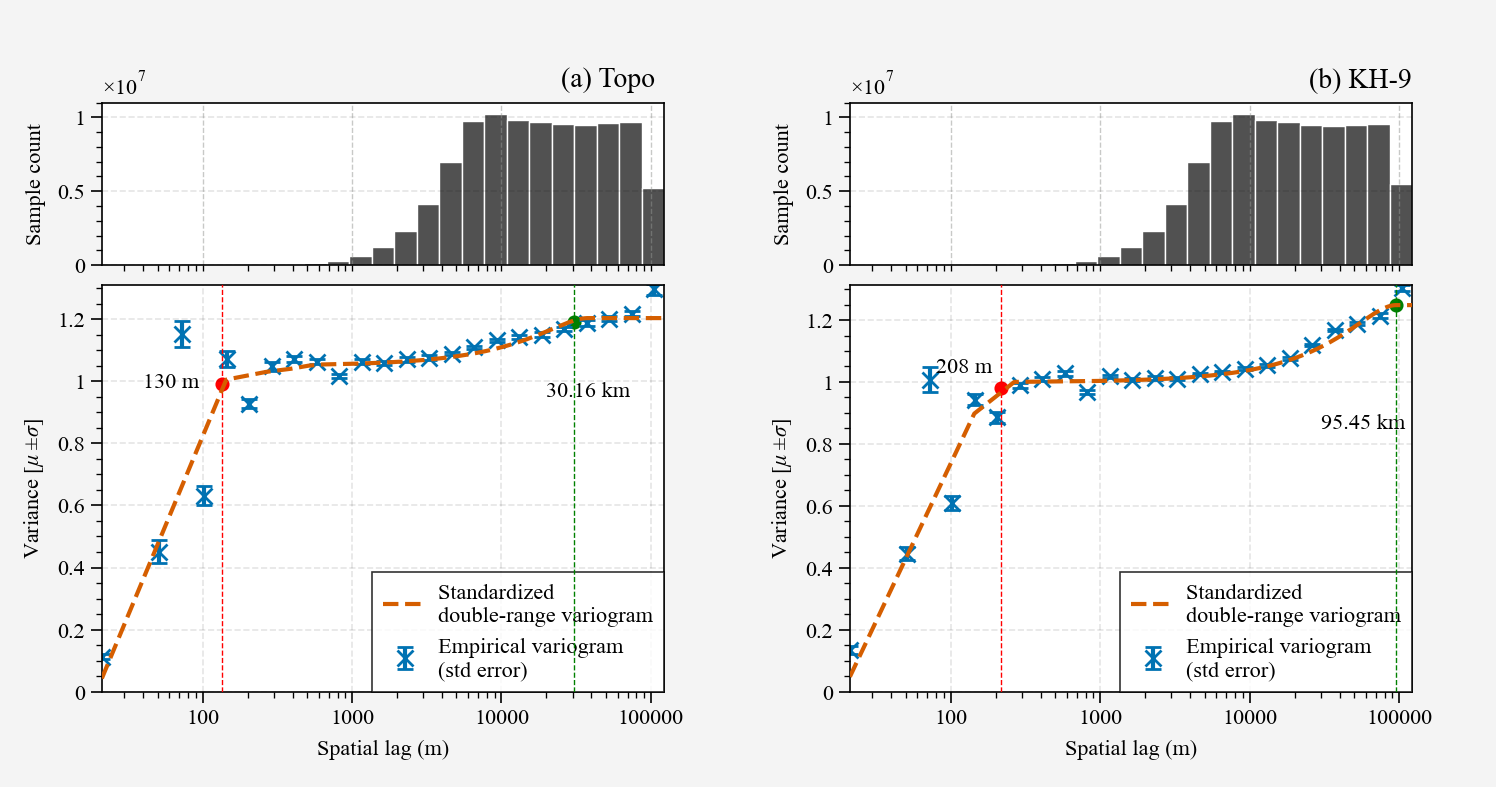

In [299]:
 #####绘制变差图，用于检测空间自相关信息
plt.rcParams['font.sans-serif']=['times new roman']
plt.rcParams['font.size']=8
plt.rcParams['grid.linestyle']='--'
fig,ax=pplt.subplots((1,2),figsize=('19cm','10cm'))
#plt.subplots_adjust(hspace=0.0)
fignm0='Figs/spatial_corr_log.tif'

ax01,axt1=plot_variogram(df_vgm2,xscale='log',list_fit_fun=[func_sum_vgm2],
    list_fit_fun_label=["Standardized \ndouble-range variogram"],ax=ax[0],flag=1)
ax0,axt=plot_variogram(df_vgm1,xscale='log',list_fit_fun=[func_sum_vgm1],
    list_fit_fun_label=["Standardized \ndouble-range variogram"],ax=ax[1])
#plt.savefig(fignm0,dpi=600,bbox_inches='tight')
axt.vlines(218,0,120,zorder=10,color='r',ls='--',lw=0.5)
axt.scatter(218,0.981,color='r',markersize=20)
axt.text(80,1.03,'208 m')
axt.vlines(95000,0,1.65,zorder=10,color='g',ls='--',lw=0.5)
axt.scatter(95000,1.25,color='g',markersize=20)
axt.text(30000,0.85,'95.45 km')
#############################
axt1.vlines(135,0,120,zorder=10,color='r',ls='--',lw=0.5)
axt1.scatter(135,0.99,color='r',markersize=20)
axt1.text(40,0.98,'130 m')
axt1.vlines(30600,0,1.45,zorder=10,color='g',ls='--',lw=0.5)
axt1.scatter(30600,1.19,color='g',markersize=20)
axt1.text(20000,0.95,'30.16 km')
axt1.legend(loc='lr',ncol=1,frameon=True,zorder=11)

axt.legend(loc='lr',ncol=1,frameon=True,zorder=11)
################
ax0.vlines([100,1000,10000,100000],0,1.1e7,color='gray',ls='--',lw=0.5,alpha=0.5)
ax01.vlines([100,1000,10000,100000],0,1.1e7,color='gray',ls='--',lw=0.5,alpha=0.5)
###########
axt.text(25000,1.95,'(b) KH-9',fontsize=10)
axt1.text(25000,1.95,'(a) Topo',fontsize=10)
plt.savefig(fignm0,dpi=600,bbox_inches='tight')

#### 绘制坡度曲率图

In [175]:
def calttt(pth000,gla,dem):
    dh = xdem.DEM(pth000)
    
    ref_dem0 = xdem.DEM(dem)
    ref_dem=ref_dem0.reproject(dh)
    glacier_outlines = gu.Vector(gla)
    # Compute the slope and maximum curvature
    slope, planc, profc = xdem.terrain.get_terrain_attribute(
        dem=ref_dem, attribute=["slope", "planform_curvature", "profile_curvature"]
    )
    
    mask_glacier = glacier_outlines.create_mask(dh)
    # Remove values on unstable terrain
    dh_arr = dh[~mask_glacier].filled(np.nan)
    slope_arr = slope[~mask_glacier].filled(np.nan)
    planc_arr = planc[~mask_glacier].filled(np.nan)
    profc_arr = profc[~mask_glacier].filled(np.nan)
    maxc_arr= np.maximum(np.abs(planc_arr), np.abs(profc_arr))
    # Remove large outliers
    dh_arr[np.abs(dh_arr) > 3 * xdem.spatialstats.nmad(dh_arr)] = np.nan
    custom_bin_slope = np.unique(
        np.concatenate(
            [
                np.nanquantile(slope_arr, np.linspace(0, 0.95, 20)),
                np.nanquantile(slope_arr, np.linspace(0.96, 0.99, 5)),
                np.nanquantile(slope_arr, np.linspace(0.991, 1, 10)),
            ]
        )
    )
    
    custom_bin_curvature = np.unique(
        np.concatenate(
            [
                np.nanquantile(maxc_arr, np.linspace(0, 0.95, 20)),
                np.nanquantile(maxc_arr, np.linspace(0.96, 0.99, 5)),
                np.nanquantile(maxc_arr, np.linspace(0.991, 1, 10)),
            ]
        )
    )
    
    df = xdem.spatialstats.nd_binning(
        values=dh_arr,
        list_var=[slope_arr, maxc_arr],
        list_var_names=["slope", "maxc"],
        statistics=["count", np.nanmedian, xdem.spatialstats.nmad],
        list_var_bins=[custom_bin_slope, custom_bin_curvature],
    )
    df = xdem.spatialstats.nd_binning(
    values=dh_arr,
    list_var=[slope_arr, maxc_arr],
    list_var_names=["slope", "maxc"],
    statistics=["count", np.nanmedian, xdem.spatialstats.nmad],
    list_var_bins=[custom_bin_slope, custom_bin_curvature],)
    return df

In [176]:
kh9_bf_pth1='results/kh9_bf_clp.tif'
topo_bf_pth1='results/topo_bf_clp.tif'
kh9_af_pth1='results/kh9_af_clp.tif'
topo_af_pth1='results/topo_af_clp.tif'

In [177]:
dfpt_kh9=calttt(kh9_af_pth1,gla,dem)

In [178]:
dfpt_topo=calttt(topo_af_pth1,gla,dem)

In [179]:
dfpt_topo

,nd,count,nanmedian,nmad,slope,maxc
0,1,33516.0,-0.764160,8.761312,"[0.0, 1.012750369636371)",NaN
1,1,60619.0,1.223145,6.623197,"[1.012750369636371, 2.1342998941463125)",NaN
2,1,81672.0,1.690186,6.534878,"[2.1342998941463125, 3.3214321859461395)",NaN
3,1,112859.0,2.362793,6.971767,"[3.3214321859461395, 4.822542232360713)",NaN
4,1,138842.0,3.148926,7.355086,"[4.822542232360713, 6.804089732608741)",NaN
...,...,...,...,...,...,...
1151,2,9.0,-3.056396,26.534776,"[67.77116672935023, 84.2218646990364)","[3.792349857016295, 4.0064288935864285)"
1152,2,15.0,13.610596,27.088217,"[67.77116672935023, 84.2218646990364)","[4.0064288935864285, 4.279804554489888)"
1153,2,14.0,-0.434814,24.962409,"[67.77116672935023, 84.2218646990364)","[4.279804554489888, 4.689934321110969)"
1154,2,31.0,-7.004883,25.540825,"[67.77116672935023, 84.2218646990364)","[4.689934321110969, 5.440011198656819)"


In [283]:
import matplotlib.colors as colors
def plot_2d_binning(
    df: pd.DataFrame,
    var_name_1: str,
    var_name_2: str,
    statistic_name: str,
    label_var_name_1: str,
    label_var_name_2: str,
    label_statistic: str,
    cmap: matplotlib.colors.Colormap = plt.cm.Reds,
    min_count: int = 30,
    scale_var_1: str = "linear",
    scale_var_2: str = "linear",
    vmin: np.floating[Any] = None,
    vmax: np.floating[Any] = None,
    nodata_color: str = "yellow",
    ax: matplotlib.axes.Axes = None,
    out_fname: str = None,
) -> None:


    # Create axes
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = plt.subplot(111)
    elif isinstance(ax, matplotlib.axes.Axes):
        fig = ax.figure
    else:
        raise ValueError("ax must be a matplotlib.axes.Axes instance or None.")

    if var_name_1 not in df.columns.values:
        raise ValueError(f'The variable "{var_name_1}" is not part of the provided dataframe column names.')
    elif var_name_2 not in df.columns.values:
        raise ValueError(f'The variable "{var_name_2}" is not part of the provided dataframe column names.')

    if statistic_name not in df.columns.values:
        raise ValueError(f'The statistic "{statistic_name}" is not part of the provided dataframe column names.')

    # Re-format pandas interval if read from CSV as string
    for var in [var_name_1, var_name_2]:
        if any(isinstance(x, pd.Interval) for x in df[var].values):
            pass
        # Check for any unformatted interval (saving and reading a pd.DataFrame without MultiIndexing transforms
        # pd.Interval into strings)
        elif any(isinstance(_pandas_str_to_interval(x), pd.Interval) for x in df[var].values):
            intervalindex_vals = [_pandas_str_to_interval(x) for x in df[var].values]
            df[var] = pd.IntervalIndex(intervalindex_vals)
        else:
            raise ValueError("The variable columns must be provided as string or pd.Interval values.")

    # Hide axes for the main subplot (which will be subdivded)
    ax.axis("off")

    # Subsample to 2D and for the variables of interest
    df_sub = df[
        np.logical_and.reduce(
            (
                df.nd == 2,
                np.isfinite(pd.IntervalIndex(df[var_name_1]).mid),
                np.isfinite(pd.IntervalIndex(df[var_name_2]).mid),
            )
        )
    ].copy()
    # Remove statistic calculated in bins with too low count
    df_sub.loc[df_sub["count"] < min_count, statistic_name] = np.nan

    # Let's do a 4 panel figure:
    # two histograms for the binning variables
    # + a colored grid to display the statistic calculated on the value of interest
    # + a legend panel with statistic colormap and nodata color

    # For some reason the scientific notation displays weirdly for default figure size
    grid = plt.GridSpec(10, 10, wspace=0.5, hspace=0.5)

    # First, an horizontal axis on top to plot the sample histogram of the first variable
    ax0 = ax.inset_axes(grid[:3, :-3].get_position(fig).bounds)
    ax0.set_xscale(scale_var_1)
    ax0.set_xticklabels([])

    # Plot the histogram manually with fill_between
    interval_var_1 = pd.IntervalIndex(df_sub[var_name_1])
    df_sub["var1_mid"] = interval_var_1.mid.values
    unique_var_1 = np.unique(df_sub.var1_mid)
    list_counts = []
    for i in range(len(unique_var_1)):
        df_var1 = df_sub[df_sub.var1_mid == unique_var_1[i]]
        count = np.nansum(df_var1["count"].values)
        list_counts.append(count)
        ax0.fill_between(
            [df_var1[var_name_1].values[0].left, df_var1[var_name_1].values[0].right],
            [0] * 2,
            [count] * 2,
            facecolor=plt.cm.Greys(0.75),
            alpha=1,
            edgecolor="white",
            linewidth=0.5,
        )
    ax0.set_ylabel("Sample count")
    # In case the axis value does not agree with the scale (e.g., 0 for log scale)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax0.set_ylim((0, 1.1 * np.max(list_counts)))
        ax0.set_xlim((np.min(interval_var_1.left), np.max(interval_var_1.right)))
    ax0.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax0.spines["top"].set_visible(False)
    ax0.spines["right"].set_visible(False)
    # Try to identify if the count is always the same
    if np.sum(~(np.abs(list_counts[0] - np.array(list_counts)) < 5)) <= 2:
        ax0.text(
            0.5,
            0.5,
            "Fixed number of\nsamples: " + f"{int(list_counts[0]):,}",
            ha="center",
            va="center",
            fontweight="bold",
            transform=ax0.transAxes,
            bbox=dict(facecolor="white", alpha=0.8),
        )

    # Second, a vertical axis on the right to plot the sample histogram of the second variable
    ax1 = ax.inset_axes(grid[3:, -3:].get_position(fig).bounds)
    ax1.set_yscale(scale_var_2)
    ax1.set_yticklabels([])

    # Plot the histogram manually with fill_between
    interval_var_2 = pd.IntervalIndex(df_sub[var_name_2])
    df_sub["var2_mid"] = interval_var_2.mid.values
    unique_var_2 = np.unique(df_sub.var2_mid)
    list_counts = []
    for i in range(len(unique_var_2)):
        df_var2 = df_sub[df_sub.var2_mid == unique_var_2[i]]
        count = np.nansum(df_var2["count"].values)
        list_counts.append(count)
        ax1.fill_between(
            [0, count],
            [df_var2[var_name_2].values[0].left] * 2,
            [df_var2[var_name_2].values[0].right] * 2,
            facecolor=plt.cm.Greys(0.75),
            alpha=1,
            edgecolor="white",
            linewidth=0.5,
        )
    ax1.set_xlabel("Sample count")
    # In case the axis value does not agree with the scale (e.g., 0 for log scale)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax1.set_xlim((0, 1.1 * np.max(list_counts)))
        ax1.set_ylim((np.min(interval_var_2.left), np.max(interval_var_2.right)))
    ax1.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    # Try to identify if the count is always the same
    if np.sum(~(np.abs(list_counts[0] - np.array(list_counts)) < 5)) <= 2:
        ax1.text(
            0.5,
            0.5,
            "Fixed number of\nsamples: " + f"{int(list_counts[0]):,}",
            ha="center",
            va="center",
            fontweight="bold",
            transform=ax1.transAxes,
            rotation=90,
            bbox=dict(facecolor="white", alpha=0.8),
        )

    # Third, an axis to plot the data as a colored grid
    ax2 = ax.inset_axes(grid[3:, :-3].get_position(fig).bounds)

    # Define limits of colormap is none are provided, robust max and min using percentiles
    if vmin is None and vmax is None:
        vmax = np.nanpercentile(df_sub[statistic_name].values, 99)
        vmin = np.nanpercentile(df_sub[statistic_name].values, 1)

    # Create custom colormap
    col_bounds = np.array([vmin, np.mean(np.asarray([vmin, vmax])), vmax])
    cb = []
    cb_val = np.linspace(0, 1, len(col_bounds))
    for j in range(len(cb_val)):
        cb.append(cmap(cb_val[j]))
    cmap_cus = colors.LinearSegmentedColormap.from_list(
        "my_cb", list(zip((col_bounds - min(col_bounds)) / (max(col_bounds - min(col_bounds))), cb)), N=1000
    )

    # Plot a 2D colored grid using fill_between
    for i in range(len(unique_var_1)):
        for j in range(len(unique_var_2)):
            df_both = df_sub[np.logical_and(df_sub.var1_mid == unique_var_1[i], df_sub.var2_mid == unique_var_2[j])]

            stat = df_both[statistic_name].values[0]
            if np.isfinite(stat):
                stat_col = max(0.0001, min(0.9999, (stat - min(col_bounds)) / (max(col_bounds) - min(col_bounds))))
                col = cmap_cus(stat_col)
            else:
                col = nodata_color

            ax2.fill_between(
                [df_both[var_name_1].values[0].left, df_both[var_name_1].values[0].right],
                [df_both[var_name_2].values[0].left] * 2,
                [df_both[var_name_2].values[0].right] * 2,
                facecolor=col,
                alpha=1,
                edgecolor="white",
            )

    ax2.set_xlabel(label_var_name_1)
    ax2.set_ylabel(label_var_name_2)
    ax2.set_xscale(scale_var_1)
    ax2.set_yscale(scale_var_2)
    # In case the axis value does not agree with the scale (e.g., 0 for log scale)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax2.set_xlim((np.min(interval_var_1.left), np.max(interval_var_1.right)))
        ax2.set_ylim((np.min(interval_var_2.left), np.max(interval_var_2.right)))

    # Fourth and finally, add a colormap and nodata color to the legend
    axcmap = ax.inset_axes(grid[:3, -3:].get_position(fig).bounds)

    # Remove ticks, labels, frame
    axcmap.set_xticks([])
    axcmap.set_yticks([])
    axcmap.spines["top"].set_visible(False)
    axcmap.spines["left"].set_visible(False)
    axcmap.spines["right"].set_visible(False)
    axcmap.spines["bottom"].set_visible(False)

    # Create an inset axis to manage the scale of the colormap
    cbaxes = axcmap.inset_axes([0, 0.75, 1, 0.1], label="cmap")

    # Create colormap object and plot
    norm = colors.Normalize(vmin=min(col_bounds), vmax=max(col_bounds))
    sm = plt.cm.ScalarMappable(cmap=cmap_cus, norm=norm)
    sm.set_array([])
    cb = plt.colorbar(sm, cax=cbaxes, orientation="horizontal", extend="both", shrink=0.8,fraction=0.05,aspect=30)
    cb.ax.tick_params(width=1.5, length=2)
    cb.set_label(label_statistic,labelpad=1)

    # Create an inset axis to manage the scale of the nodata legend
    nodata = axcmap.inset_axes([0.1, 0.1, 0.2, 0.2], label="nodata")

    # Plot a nodata legend
    nodata.fill_between([0, 0.5], [0, 0], [0.5, 0.5], facecolor=nodata_color)
    nodata.set_xlim((0, 0.5))
    nodata.set_ylim((0, 0.5))
    nodata.set_xticks([])
    nodata.set_yticks([])
    nodata.text(0.91, 0.35, "No data", ha="center", va="top")

    if out_fname is not None:
        plt.savefig(out_fname)

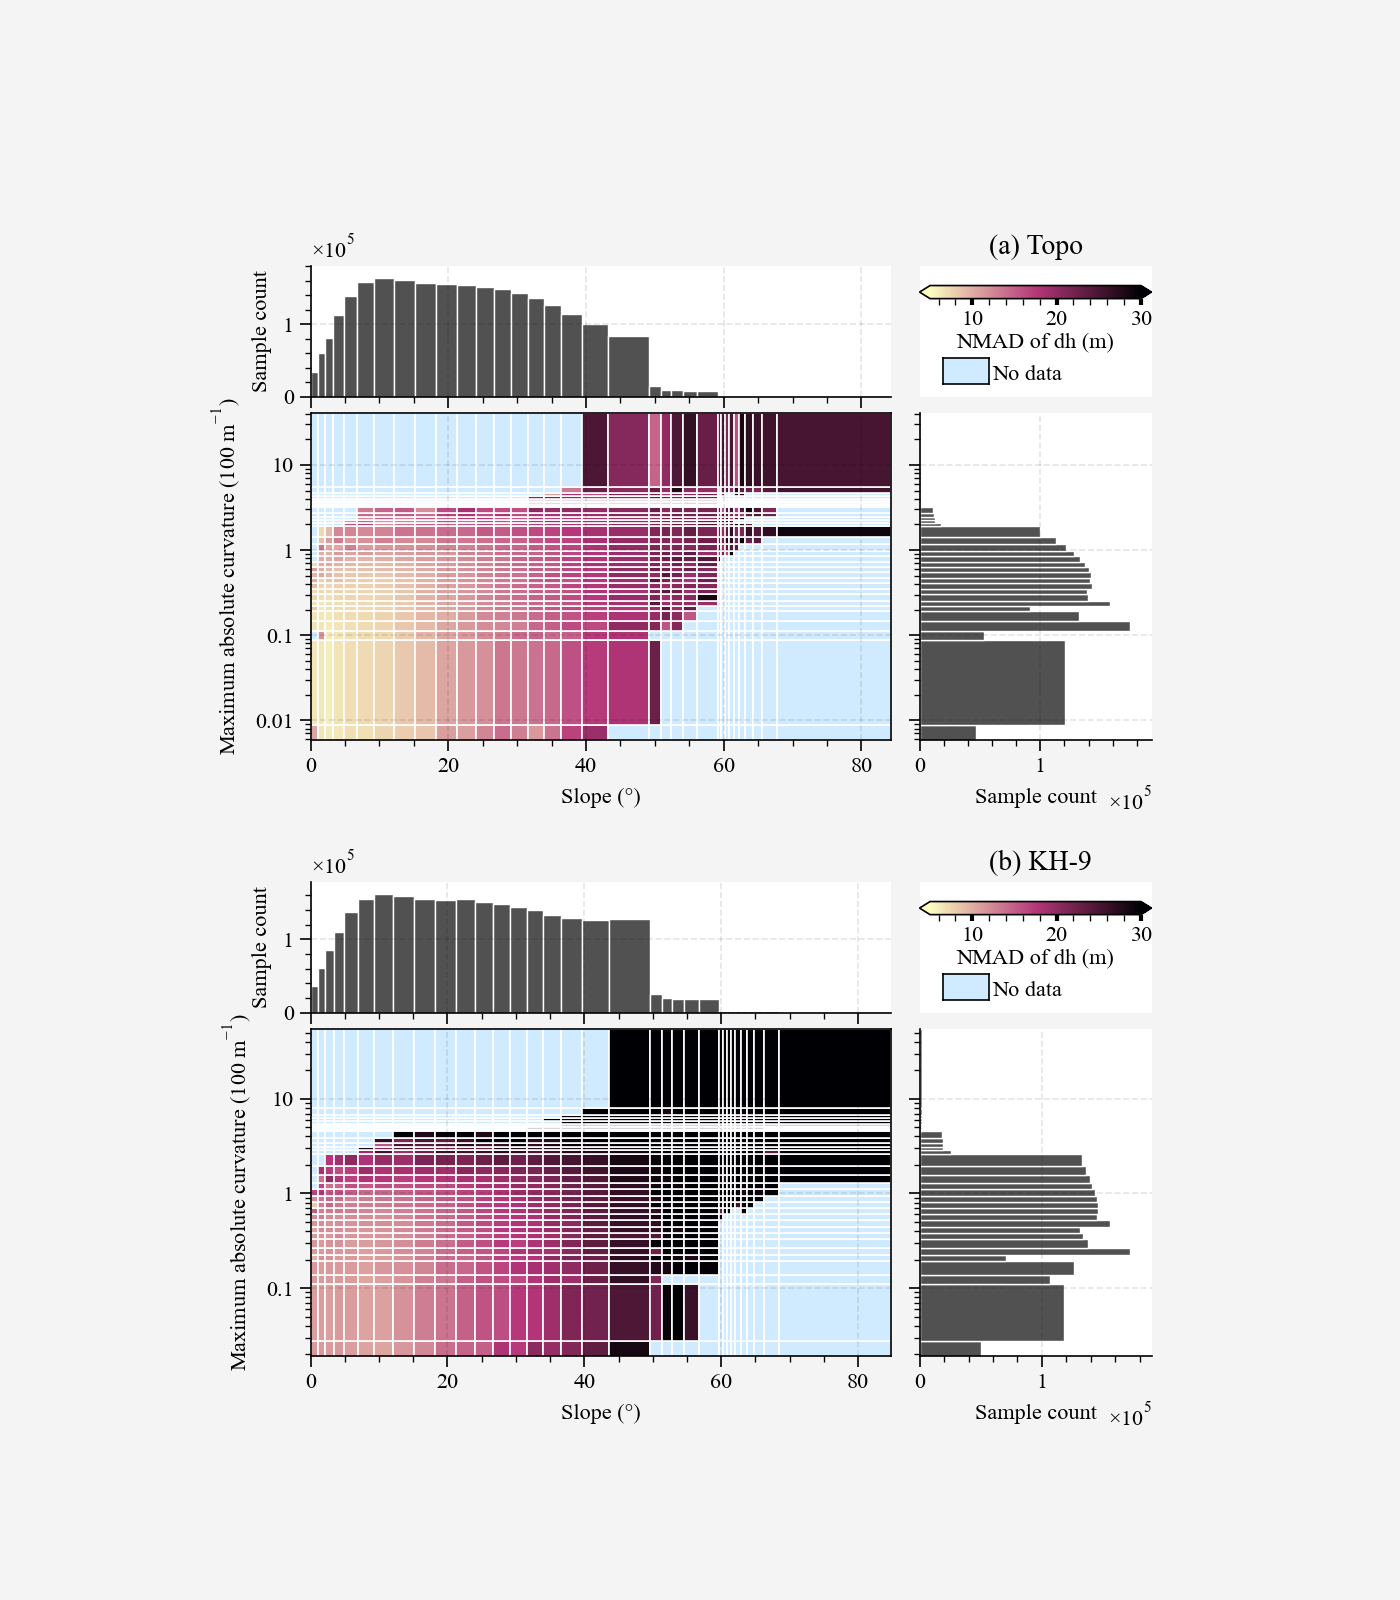

In [295]:
 #####绘制变差图，用于检测空间自相关信息
plt.rcParams['font.sans-serif']=['times new roman']
plt.rcParams['font.size']=8
plt.rcParams['grid.linestyle']='--'
fig,ax=plt.subplots(2,1,figsize=(7,8))
plt.subplots_adjust(hspace=0.0)
fignm0='Figs/spatial_corr_log.tif'
plot_2d_binning(dfpt_topo,"slope","maxc","nmad",
    "Slope (°)","Maximum absolute curvature (100 m$^{-1}$)","NMAD of dh (m)",
    scale_var_2="log",vmin=5,vmax=30,cmap=plt.cm.magma_r,min_count=30,nodata_color='blue1',ax=ax[0])
plot_2d_binning(dfpt_kh9,"slope","maxc","nmad",
    "Slope (°)","Maximum absolute curvature (100 m$^{-1}$)","NMAD of dh (m)",
    scale_var_2="log",vmin=5,vmax=30,cmap=plt.cm.magma_r,min_count=30,nodata_color='blue1',ax=ax[1])
ax[0].text(0.75,0.90,'(a) Topo',fontsize=10)
ax[1].text(0.75,0.90,'(b) KH-9',fontsize=10)
plt.savefig('Figs/slope_curva_error.tif',dpi=600,bbox_inches='tight')

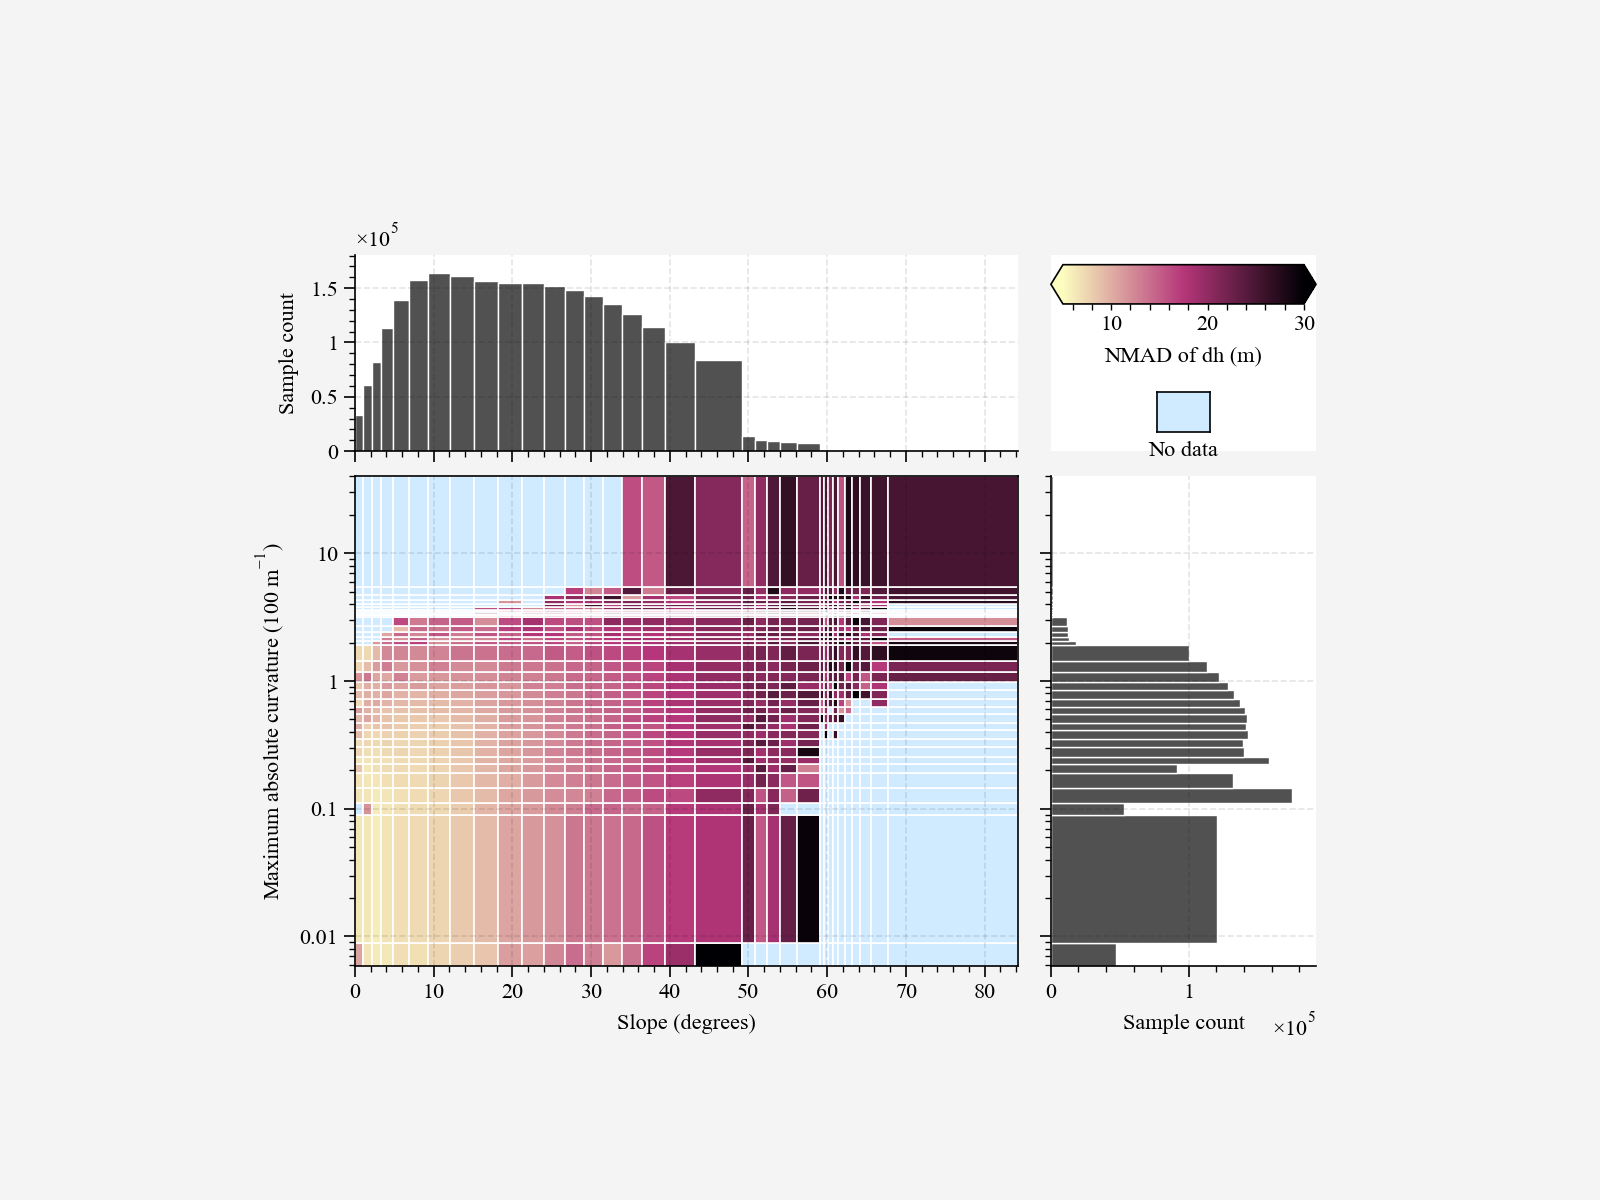

In [212]:
xdem.spatialstats.plot_2d_binning(
    dfpt_topo,
    "slope",
    "maxc",
    "nmad",
    "Slope (°)",
    "Maximum absolute curvature (100 m$^{-1}$)",
    "NMAD of dh (m)",
    scale_var_2="log",
    vmin=5,
    vmax=30,
    cmap=plt.cm.magma_r,
    min_count=10,
    nodata_color='blue1'
)

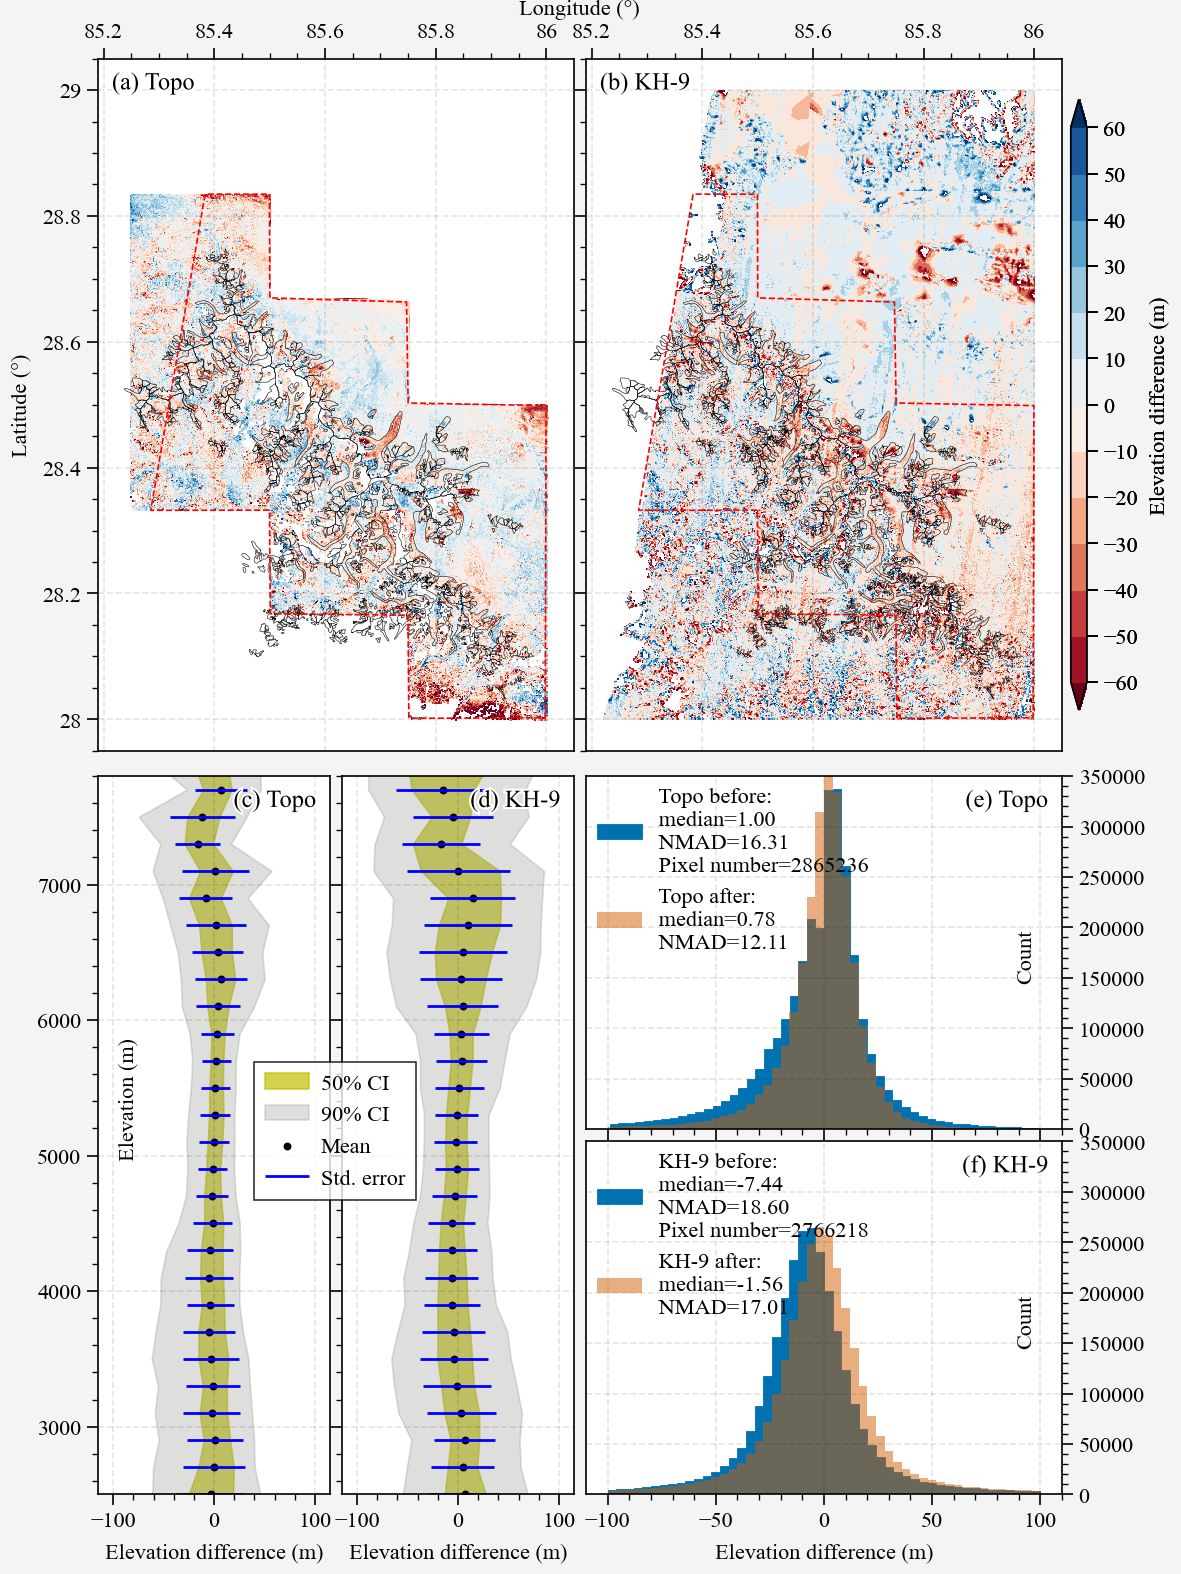

In [27]:
!pip show matplotlib

Name: matplotlib
Version: 3.4.3
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: c:\miniconda3\envs\py39\lib\site-packages
Requires: cycler, kiwisolver, numpy, pillow, pyparsing, python-dateutil
Required-by: basemap, Cartopy, colourmap, distfit, geemap, geoutils, proplot, pyextremes, scikit-gstat, seaborn, xdem
